In [1]:
from nba_api.stats.static import teams
from nba_api.stats.endpoints import teamyearbyyearstats
import pandas as pd
import matplotlib.pyplot as plt
import requests
import numpy as np
from pprint import pprint

In [ ]:
# average points against each team for the specific year in the regular season to be manually entered
opponents_scores = [107.6, 108.4, 107.5, 104.3, 98.3, 99.9, 97.6, 95.0, 92.5, 96.0,
                    97.0, 99.3, 90.3, 90.1, 96.0, 88.4, 84.3, 90.4, 94.1, 97.2, 92.3]

In [2]:
# import manually made nba champions csv to df
champ_stats_df = pd.read_csv('Resources/champs_stats.csv')
champ_stats_df.head()

,Year,Team,Points Against,Result
0,2020,Los Angeles Lakers,107.6,4-2
1,2019,Toronto Raptors,108.4,4-2
2,2018,Golden State Warriors,107.5,4-0
3,2017,Golden State Warriors,104.3,4-1
4,2016,Cleveland Cavaliers,98.3,4-3


In [3]:
# access nba api static endpoint to get team id
nba_teams = teams.get_teams()
all_champs = champ_stats_df['Team']
team_ids = {}
year = 2020
# loop through the team names in our df
for champ in all_champs:
    # search for team id using api and add to team_ids dict. The key used is the year the team won the championship
    # convert to string to add to dict and then convert back to int to make the next key the prior year
    team_ids[str(year)] = str([team for team in nba_teams if team["full_name"] == f'{champ}'][0]['id'])
    year = int(year) - 1
    

# lakers_id = [team for team in nba_teams if team["full_name"] == "Los Angeles Lakers"][0]['id']
# raptors_id = [team for team in nba_teams if team["full_name"] == "Toronto Raptors"][0]['id']
# warriors_id = [team for team in nba_teams if team["full_name"] == "Golden State Warriors"][0]['id']
# cavs_id = [team for team in nba_teams if team["full_name"] == "Cleveland Cavaliers"][0]['id']
# spurs_id = [team for team in nba_teams if team["full_name"] == "San Antonio Spurs"][0]['id']
# heat_id = [team for team in nba_teams if team["full_name"] == "Miami Heat"][0]['id']
# mavs_id = [team for team in nba_teams if team["full_name"] == "Dallas Mavericks"][0]['id']
# celtics_id = [team for team in nba_teams if team["full_name"] == "Boston Celtics"][0]['id']
# pistons_id = [team for team in nba_teams if team["full_name"] == "Detroit Pistons"][0]['id']
# print(lakers_id, raptors_id, warriors_id, cavs_id, spurs_id, heat_id, mavs_id, celtics_id, pistons_id)

In [7]:
# Note - team id is [0], city is [1], name is [2], Year is [3], GP is [4], wins is [5], win pct is [7], pts is [-2], lakers first on list is -5

# create dictionary and start from the 2019-2020 season
full_team_info = {}
i = -5

# Loop for each year and team id in my team_ids dict
for year, identity in team_ids.items():
    # return dict from nba_api endpoint
    team_info = teamyearbyyearstats.TeamYearByYearStats(league_id='00', per_mode_simple='Totals', season_type_all_star='Regular Season', team_id=identity).get_dict()
    # access the keys and lists of the returned dictionary to get our team info and stats to put into team_dict
    team_dict = {
        'City': team_info['resultSets'][0]['rowSet'][i:][0][1],
        'Team': team_info['resultSets'][0]['rowSet'][i:][0][2],
        'ID': str(team_info['resultSets'][0]['rowSet'][i:][0][0]),
        'Games Played': team_info['resultSets'][0]['rowSet'][i:][0][4],
        'Win %': team_info['resultSets'][0]['rowSet'][i:][0][7],
        'Points': team_info['resultSets'][0]['rowSet'][i:][0][-2]
    }
    # add the team_dict to the full_team info dict, with the year played as the key to avoid duplicate values
    year_played = team_info['resultSets'][0]['rowSet'][i:][0][3]
    full_team_info[year_played] = team_dict
    # decrease index to return info for previous year
    i = i-1

In [36]:
# getting all team hex colors
primary_hex_colors = {}
secondary_hex_colors = {}
for champ in all_champs:
    primary_hex_colors[champ] = None
    secondary_hex_colors[champ] = None
    
primary_hex_colors['Los Angeles Lakers'] = '#552583'
primary_hex_colors['Toronto Raptors'] = '#ce1141'
primary_hex_colors['Golden State Warriors'] = '#1d428a'
primary_hex_colors['Cleveland Cavaliers'] = '#860038'
primary_hex_colors['San Antonio Spurs'] = '#c4ced4'
primary_hex_colors['Miami Heat'] = '#98002e'
primary_hex_colors['Dallas Mavericks'] = '#00538c'
primary_hex_colors['Boston Celtics'] = '#007a33'
primary_hex_colors['Detroit Pistons'] = '#c8102e'

secondary_hex_colors['Los Angeles Lakers'] = '#f9a01b'
secondary_hex_colors['Toronto Raptors'] = '#a1a1a4'
secondary_hex_colors['Golden State Warriors'] = '#ffc72c'
secondary_hex_colors['Cleveland Cavaliers'] = '#041e42'
secondary_hex_colors['San Antonio Spurs'] = '#000000'
secondary_hex_colors['Miami Heat'] = '#f9a01b'
secondary_hex_colors['Dallas Mavericks'] = '#b8c4ca'
secondary_hex_colors['Boston Celtics'] = '#ba9653'
secondary_hex_colors['Detroit Pistons'] = '#1d42ba'

In [37]:
# create df and rename index column
full_team_stats_df = pd.DataFrame(full_team_info, index=None).T.reset_index()
full_team_stats_df = full_team_stats_df.rename(columns={'index': 'Year'})

# Create a column for points per game in regular season and round to 1 decimal place
full_team_stats_df['Points Per Game'] = full_team_stats_df['Points'] / full_team_stats_df['Games Played']
full_team_stats_df = full_team_stats_df.astype({'Points Per Game': 'float'})
full_team_stats_df['Points Per Game'] = full_team_stats_df['Points Per Game'].round(1)

# add the points against average from the first dataframe to our new df. And calculate the point differential between the averages
full_team_stats_df['Points Against Per Game'] = champ_stats_df['Points Against']
full_team_stats_df['Point Differential'] = (full_team_stats_df['Points Per Game'] - full_team_stats_df['Points Against Per Game']).round(1)

# adding team hex colors to df by matching key of dict to team name in df and then adding hex value for a match
full_team_stats_df['Hex Color Primary'] = (full_team_stats_df['City'] + ' ' + full_team_stats_df['Team']).map(primary_hex_colors)
full_team_stats_df['Hex Color Secondary'] = (full_team_stats_df['City'] + ' ' + full_team_stats_df['Team']).map(secondary_hex_colors)

# Combining name and year of teams
full_team_stats_df['Team and Year'] = full_team_stats_df['Year'] + ' ' + full_team_stats_df['Team']

# export the df to a csv
full_team_stats_df.to_csv('Resources/regular_season_stats_champs.csv', index=False, header=True)
full_team_stats_df.head()

,Year,City,Team,ID,Games Played,Win %,Points,Points Per Game,Points Against Per Game,Point Differential,Hex Color Primary,Hex Color Secondary,Team and Year
0,2019-20,Los Angeles,Lakers,1610612747,71,0.732,8054,113.4,107.6,5.8,#552583,#f9a01b,2019-20 Lakers
1,2018-19,Toronto,Raptors,1610612761,82,0.707,9384,114.4,108.4,6.0,#ce1141,#a1a1a4,2018-19 Raptors
2,2017-18,Golden State,Warriors,1610612744,82,0.707,9304,113.5,107.5,6.0,#1d428a,#ffc72c,2017-18 Warriors
3,2016-17,Golden State,Warriors,1610612744,82,0.817,9503,115.9,104.3,11.6,#1d428a,#ffc72c,2016-17 Warriors
4,2015-16,Cleveland,Cavaliers,1610612739,82,0.695,8555,104.3,98.3,6.0,#860038,#041e42,2015-16 Cavaliers


In [38]:
# narrow df for analysis
regular_season_analysis_df = full_team_stats_df[['Team and Year', 'Win %', 'Point Differential', 'Hex Color Primary', 'Hex Color Secondary']]
regular_season_analysis_df.columns = ['Team', 'Win %', 'Point Differential', 'Hex Color Primary', 'Hex Color Secondary']
regular_season_analysis_df = regular_season_analysis_df.sort_values(by='Point Differential', ascending=False)

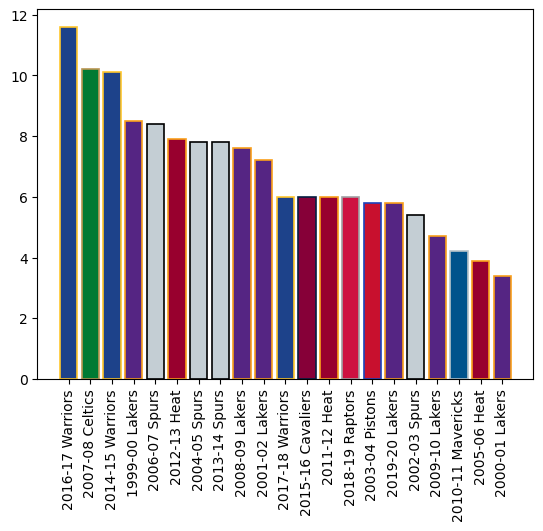

In [39]:
teams_analysis_reg = regular_season_analysis_df['Team']
point_differential_reg = regular_season_analysis_df['Point Differential']
plt.bar(teams_analysis_reg, point_differential_reg, color=regular_season_analysis_df['Hex Color Primary'], edgecolor=regular_season_analysis_df['Hex Color Secondary'], linewidth=1.2)
plt.xticks(rotation=90)
plt.show()